# Whales Dataset

In [1]:
from math import ceil
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.ensemble import IsolationForest

import util
from util.drawing import plot_isolation_forest
from util.graph import edges_on_path
from util.incidence import create_node_edge_incidence_matrix, create_edge_triangle_incidence_matrix, create_normalized_l1, create_triangle_list
from util.io import read_dataset
from util.trajectory import full_trajectory_matrix, flatten_trajectory_matrix, interpolate_trajectory, create_matrix_coordinates_trajectory_Hspace, harmonic_projection_matrix

sns.set_theme()

## Load Data

In [2]:
storage_dir = Path('.') / 'cache' / 'whales'

hexagonal_world, dataframe = read_dataset(storage_dir / 'dataset.pickle')
individuals = pd.unique(dataframe.index.get_level_values(0))

print(f'The dataset contains {len(individuals)} trajectories with an average length of {len(dataframe) / len(individuals)}.')
display(dataframe)

The dataset contains 41 trajectories with an average length of 868.5365853658536.


event-id  visible  longitude  latitude  \
identifier timestamp                                                        
39146      2008-08-16 23:27:00  12049635403     True    -86.065    72.680   
           2008-08-17 11:21:00  12049635404     True    -85.960    72.289   
           2008-08-17 18:19:00  12049635407     True    -85.649    71.735   
           2008-08-17 21:24:00  12049635411     True    -86.276    72.035   
           2008-08-17 21:43:00  12049635412     True    -86.363    72.063   
...                                     ...      ...        ...       ...   
148505     2017-02-11 13:09:00  12049697202     True    -75.699    63.585   
           2017-02-11 19:19:00  12049697203     True    -75.867    63.576   
           2017-02-11 21:20:00  12049697204     True    -75.739    63.573   
           2017-02-13 03:07:00  12049697205     True    -76.341    63.680   
           2017-02-13 07:20:00  12049697206     True    -76.579    63.750   

                               argos:lc          sensor-type  \
identifier timestamp                                           
39146      2008-08-16 23:27:00        B  argos-doppler-shift   
           2008-08-17 11:21:00        B  argos-doppler-shift   
           2008-08-17 18:19:00        B  argos-doppler-shift   
           2008-08-17 21:24:00        B  argos-doppler-shift   
           2008-08-17 21:43:00        B  argos-doppler-shift   
...                                 ...                  ...   
148505     2017-02-11 13:09:00        0  argos-doppler-shift   
           2017-02-11 19:19:00        B  argos-doppler-shift   
           2017-02-11 21:20:00        0  argos-doppler-shift   
           2017-02-13 03:07:00        B  argos-doppler-shift   
           2017-02-13 07:20:00        B  argos-doppler-shift   

                               individual-taxon-canonical-name  \
identifier timestamp                                             
39146      2008-08-16 23:27:00              Balaena mysticetus   
           2008-08-17 11:21:00              Balaena mysticetus   
           2008-08-17 18:19:00              Balaena mysticetus   
           2008-08-17 21:24:00              Balaena mysticetus   
           2008-08-17 21:43:00              Balaena mysticetus   
...                                                        ...   
148505     2017-02-11 13:09:00              Balaena mysticetus   
           2017-02-11 19:19:00              Balaena mysticetus   
           2017-02-11 21:20:00              Balaena mysticetus   
           2017-02-13 03:07:00              Balaena mysticetus   
           2017-02-13 07:20:00              Balaena mysticetus   

                                tag-local-identifier  \
identifier timestamp                                   
39146      2008-08-16 23:27:00                 39146   
           2008-08-17 11:21:00                 39146   
           2008-08-17 18:19:00                 39146   
           2008-08-17 21:24:00                 39146   
           2008-08-17 21:43:00                 39146   
...                                              ...   
148505     2017-02-11 13:09:00                148505   
           2017-02-11 19:19:00                148505   
           2017-02-11 21:20:00                148505   
           2017-02-13 03:07:00                148505   
           2017-02-13 07:20:00                148505   

                                                    study-name  \
identifier timestamp                                             
39146      2008-08-16 23:27:00  Bowhead whale Cumberland Sound   
           2008-08-17 11:21:00  Bowhead whale Cumberland Sound   
           2008-08-17 18:19:00  Bowhead whale Cumberland Sound   
           2008-08-17 21:24:00  Bowhead whale Cumberland Sound   
           2008-08-17 21:43:00  Bowhead whale Cumberland Sound   
...                                                        ...   
148505     2017-02-11 13:09:00  Bowhead whale Cumberland Sound   
           2017-02

In [3]:
print(len(dataframe.loc[individuals[6]]))

1518


## Config

In [4]:
trajectory_color_palette = sns.color_palette(n_colors=len(individuals))

## Code

In [5]:
list_edges = list(map(lambda edge: (hexagonal_world.hex_to_index[edge[0]], hexagonal_world.hex_to_index[edge[1]]), hexagonal_world.edge_list()))

G = nx.Graph()
G.add_nodes_from(hexagonal_world.index_to_hex.keys())
G.add_edges_from(list_edges)

elist = np.array(G.edges())
elist = util.lexsort_rows(elist)
elist_dict = {(j[0], j[1]): i for i, j in enumerate(G.edges())}

In [6]:
B1 = create_node_edge_incidence_matrix(elist)

In [7]:
tlist = create_triangle_list(G)
B2 = create_edge_triangle_incidence_matrix(elist, tlist)

In [8]:
L1 = create_normalized_l1(B1, B2, mode="RW")

In [9]:
trajectories = []

mat_trajectory = []
for individual, individual_data in dataframe.groupby(level=0, sort=False):
    trajectory = list(map(lambda hex: hexagonal_world.hex_to_index[hex], individual_data['hex']))
    trajectory = list(interpolate_trajectory(trajectory, G))

    trajectories.append(trajectory)
    mat_trajectory.append(list(edges_on_path(trajectory)))

In [10]:
M_full = full_trajectory_matrix(G, mat_trajectory, elist, elist_dict)
M_flatten = flatten_trajectory_matrix(M_full)

In [11]:
# H = harmonic_projection_matrix(L1[0].astype(float), 2)
from scipy.sparse import linalg

_, v = linalg.eigsh(L1[0].astype(float), k=2, which='SM')
H = v.T

In [12]:
mat_coord_Hspace = create_matrix_coordinates_trajectory_Hspace(H, M_full)

### Visualization

In [13]:
# from matplotlib.cm import ScalarMappable
# from util.drawing import set_axis_limits

# with sns.axes_style('white'):
#     fig, ax = plt.subplots(figsize=(8, 6))
#     set_axis_limits(ax, hexagonal_world)

#     for triangle in create_triangle_list(G):
#         hexagons = [hexagonal_world.index_to_hex[i] for i in triangle]
#         corner_points = [hexagonal_world.layout.hex_to_pixel(hexagon) for hexagon in hexagons]
#         corners = [[point.x, point.y] for point in corner_points]
#         polygon = plt.Polygon(corners, edgecolor='white', facecolor='#e1e7e4')
#         ax.add_patch(polygon)

#     norm = plt.Normalize()
#     counts = np.abs(M_flatten).sum(axis=0)
#     counts_normalized = norm(counts)
#     cmap = sns.color_palette('flare', as_cmap=True)
#     for edge, count in zip(elist, counts_normalized):
#         if count > 0:
#             p1 = hexagonal_world.layout.hex_to_pixel(hexagonal_world.index_to_hex[edge[0]])
#             p2 = hexagonal_world.layout.hex_to_pixel(hexagonal_world.index_to_hex[edge[1]])
#             ax.arrow(p1.x, p1.y, (p1.x - p2.x), (p1.y - p2.y), color=cmap(count))
#     fig.colorbar(ScalarMappable(norm, cmap), ax=ax)

In [14]:
from matplotlib.patches import FancyArrowPatch
from matplotlib.path import Path
from util.drawing import init_world_axis, plot_hexagons_on_map

ncols = 2
fig, axes = plt.subplots(nrows=ceil(len(individuals) / ncols), ncols=ncols, sharex=True, sharey=True, squeeze=True, figsize=(20, 120))

for i, trajectory in enumerate(mat_trajectory):
    row_index = i // ncols
    col_index = i % ncols

    axes[row_index, col_index].set_title(f'Trajectory {i}; Identifier {individuals[i]}')
    init_world_axis(axes[row_index, col_index], hexagonal_world, dataframe.crs)
    # plot_hexagons_on_map(axes[row_index, col_index], hexagonal_world)

    # for hexagon in set(dataframe['hex'].loc[individuals[i]]):
    #     point = hexagonal_world.layout.hex_to_pixel(hexagon)
    #     axes[row_index, col_index].plot(point.x, point.y, 'bo', alpha=0.5)

    for from_index, to_index in trajectory:
        p1 = hexagonal_world.layout.hex_to_pixel(hexagonal_world.index_to_hex[from_index])
        p2 = hexagonal_world.layout.hex_to_pixel(hexagonal_world.index_to_hex[to_index])

        patch = FancyArrowPatch((p1.x, p1.y), (p2.x, p2.y), color=trajectory_color_palette[i])
        axes[row_index, col_index].add_patch(patch)

fig.savefig(storage_dir / f'discrete-trajectories.pdf', bbox_inches='tight')
plt.close(fig)

## Trajectory Embeddings

In [15]:
mat_coor_flatten_trajectory = [H @ mat for mat in M_flatten]

In [16]:
mat_coor = []
for i in mat_coor_flatten_trajectory:
    mat_coor.append(i.tolist())
mat_coor = np.array(mat_coor)

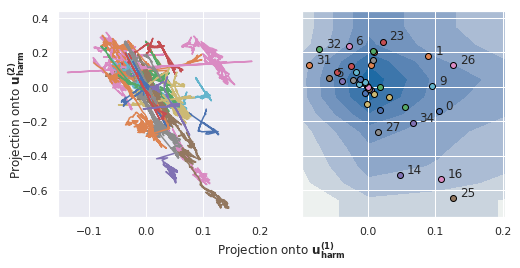

In [17]:
figsize = 8
fig, axes = plt.subplots(ncols=2, figsize=(figsize, figsize / 2 - 0.2), sharey=True)

contamination_factor = 10 / len(individuals)
isolation_forest = IsolationForest()
predictions = isolation_forest.fit_predict(mat_coor_flatten_trajectory)

cumsums = list(map(lambda i: [np.cumsum(i[0]), np.cumsum(i[1])], mat_coord_Hspace))
for i, cumsum in enumerate(cumsums):
    sns.lineplot(x=cumsum[0], y=cumsum[1], color=trajectory_color_palette[i], ax=axes[0], sort=False)

for i, embedding in enumerate(mat_coor_flatten_trajectory):
    axes[1].scatter(embedding[0], embedding[1], color=trajectory_color_palette[i], edgecolor='black')
plot_isolation_forest(isolation_forest, ax=axes[1])

for i, prediction in enumerate(predictions):
    if prediction == -1:
        axes[1].text(mat_coor_flatten_trajectory[i][0] + 0.01, mat_coor_flatten_trajectory[i][1] + 0.01, i)

ax = fig.add_subplot(111, frame_on=False)
ax.tick_params(labelcolor="none", bottom=False, left=False)
ax.grid(False)
ax.set_xlabel(r'Projection onto $\mathbf{u_{harm}^{(1)}}$')
ax.set_ylabel(r'Projection onto $\mathbf{u_{harm}^{(2)}}$')

fig.savefig(storage_dir / 'outlier_predictions.pdf', bbox_inches='tight')